# Lecture transcript from March 16: Gradient descent and its relatives

The first window below does the standard imports for CS 111. The list may change as the quarter goes on.

You should change the string in **sys.path.append()** to be the full path on your own computer to the **CS111-2023-winter/Python** directory that you got when you cloned the course GitHub site.

In [1]:
import sys

########################################
# Change the string in the line below! #
########################################
sys.path.append("/Users/gilbert/Documents/CS111-2023-winter/Python") 

import os
import time
import math
import autograd.numpy as np
import autograd.numpy.linalg as npla
from autograd import elementwise_grad, value_and_grad, grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial
import scipy
from scipy import linalg as spla
import scipy.sparse
import scipy.sparse.linalg
from scipy import integrate
import networkx as nx
import json

import cs111

#######################################################
# Here are three different ways to have plots appear. #
# Uncomment the one you want to use.                  #
#                                                     #
# inline    : static plot in notebook                 #
# ipympl    : plot in notebook with pan/zoom controls #
# tk        : plot in popup window with pan/zoom      #
#                                                     #
# If %matplotlib ipympl doesn't work, try saying:     #
#   conda install -c conda-forge ipympl               #
# at a shell prompt.                                  #
#######################################################
import matplotlib
%matplotlib inline 
# %matplotlib ipympl
# %matplotlib tk 

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation

np.set_printoptions(precision = 4)

In [2]:
plt.close('all')

In [3]:
# Define the objective function, the grid we will visualize it on, and the starting point.
# Also, since we know the minimum of each of these functions, record that for reference too.

function = 'Strang'   
# function = 'Rosenbrock'

if function == 'Beale':
    # Beale's function. See https://en.wikipedia.org/wiki/Test_functions_for_optimization
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    xmin, xmax, xstep = -4.5, 4.5, .2
    ymin, ymax, ystep = -4.5, 4.5, .2
    contours = np.logspace(0, 5, 35)
    minima = np.array([3., .5])
    x0 = np.array([3., 4.])
    
elif function == 'Rosenbrock':
    # Rosenbrock's function. See https://en.wikipedia.org/wiki/Test_functions_for_optimization
    alpha = 100
    f = lambda x, y: (1.0 - x)**2 + alpha * (y-x**2)**2
    xmin, xmax, xstep = -3.5, 2., .05
    ymin, ymax, ystep = -5., 5., .05
    contours = np.logspace(0, 5, 35)
    minima = np.array([1., 1.]) 
    x0 = np.array([-3., -4.])
    
elif function == 'Strang':
    # The simple quadratic from Gil Strang's lectures on optimization
    alpha = 0.1
    f = lambda x, y: (x**2 + alpha*y**2) / 2 
    xmin, xmax, xstep = -1., 1., .1
    ymin, ymax, ystep = -1., 1.5, .1
    contours = np.logspace(-2.5, 0, 15)
    minima = np.array([0.,0.])
    x0 = np.array([alpha,1.])
    
else:
    assert False
    


In [4]:
# Get a 2D mesh of points with a function value for each one, for visualization

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x, y)

# Get a version of the function that knows its gradient. (Sounds like magic, huh?)
# This routine uses automatic differentiation (= backpropagation) and yields a new callable 
# "func" that takes as argument the numpy array np.array([x,y]) 
# and returns the pair (f(x,y), gradient vector at (x,y))

func = value_and_grad(lambda args: f(*args))


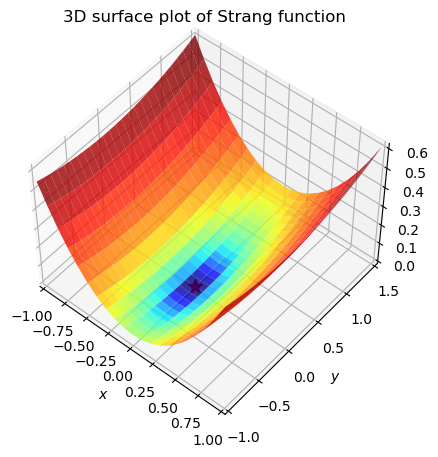

In [5]:
# Make a 3D surface plot of the objective function 

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima, f(*minima), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_title(f"3D surface plot of {function} function")

plt.show()

In [6]:
# Good parameters to show zigzag behavior with Strang's function

rate = 1.8
res = cs111.gradient_descent(func, x0, 
            rate=rate, max_iters=100, tol=.0001)
print(f"{function}: rate = {rate}, {res.nit} iterations, {res.message}")

Strang: rate = 1.8, 40 iterations, optimization terminated successfully


In [ ]:
# A good learning rate for Rosenbrock is delicate (bad version)

rate = .001
res = cs111.gradient_descent(func, x0, 
            rate=rate, max_iters=10000, tol=.01)
print(f"{function}: rate = {rate}, {res.nit} iterations, {res.message}")

In [7]:
res.costs[:10]

[0.05500000000000001,
 0.05500000000000001,
 0.03682,
 0.024654087999999998,
 0.016511053571199995,
 0.011059565093274874,
 0.007409272478798025,
 0.0049646001971949925,
 0.0033270646173626807,
 0.002229993413366678]

In [ ]:
# A good learning rate for Rosenbrock is delicate (good version)

rate = .0002
res = cs111.gradient_descent(func, x0, 
            rate=rate, max_iters=10000, tol=.0001) # try tol=.0001 and .01
print(f"{function}: rate = {rate}, {res.nit} iterations, {res.message}")

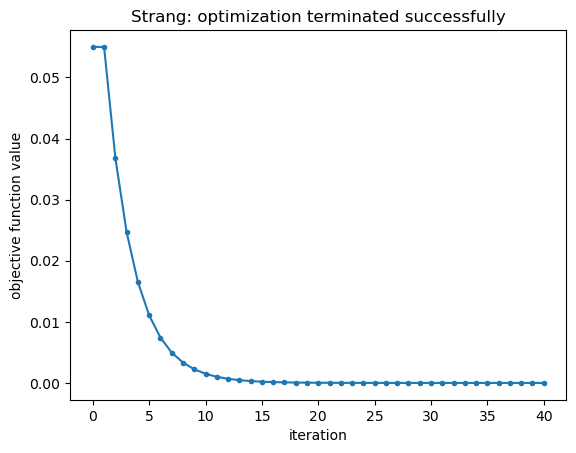

In [8]:
# Plot the objective function at each iteration

fig, ax = plt.subplots()
ax.plot(res.costs, '.-')
ax.set_xlabel('iteration')
ax.set_ylabel('objective function value')
ax.set_title(f"{function}: {res.message}")
plt.show()

Text(0.5, 1.0, 'Gradient descent for Strang function')

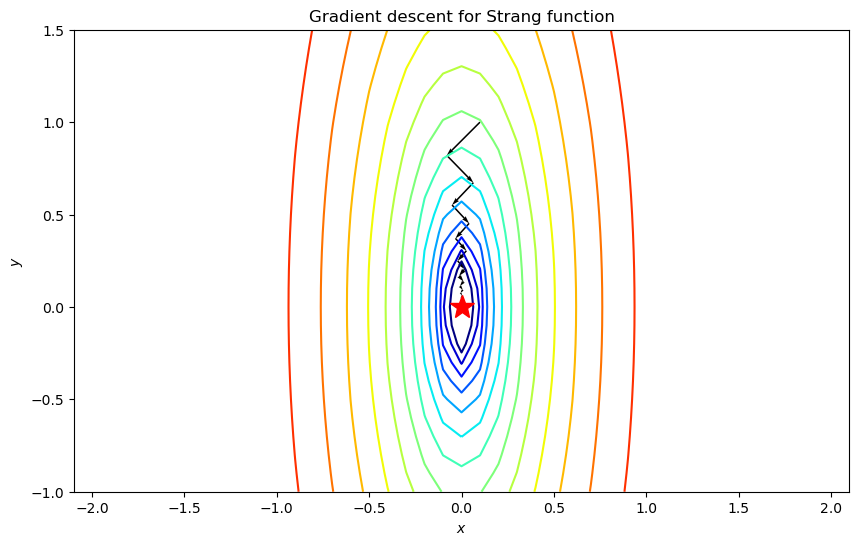

In [9]:
# Contour plot of objective function showing path of optimization

path = np.array(res.xks).T

fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=contours, norm=LogNorm(), cmap=plt.cm.jet)

ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], 
          scale_units='xy', angles='xy', scale=1, width=(xmax-xmin)/1000, color='k')
ax.plot(*minima, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.axis('equal')
ax.set_title(f"Gradient descent for {function} function")

In [10]:
# Good parameters to show effect of momentum with Strang's function

rate = 1.8
beta = .45
res2 = cs111.gradient_momentum(func, x0, 
            rate=rate, beta=beta, max_iters=100, tol=.0001)
print(f"{function}: rate = {rate}, beta = {beta}, {res2.nit} iterations, {res.message}")

Strang: rate = 1.8, beta = 0.45, 19 iterations, optimization terminated successfully


In [ ]:
# Trying momentum parameters for Rosenbrock

rate = .0002
beta = .6  # try both .6 and .75
res2 = cs111.gradient_momentum(func, x0, 
        rate=rate, beta=beta, max_iters=10000, tol=.0001) #  try .01 and .0001
print(f"{function}: rate = {rate}, beta = {beta}, {res2.nit} iterations, {res2.message}")

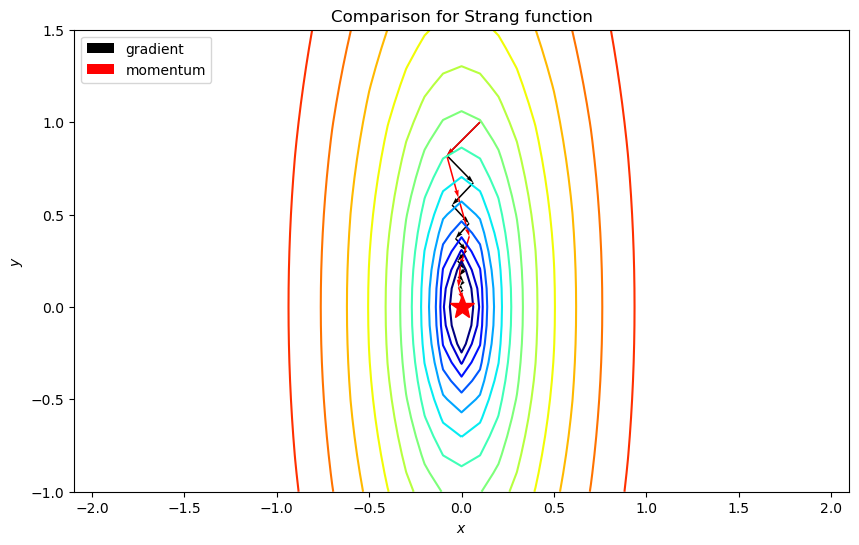

In [11]:
# Contour plot of objective function showing both gradient descent and momentum methods

path1 = np.array(res.xks).T
path2 = np.array(res2.xks).T

fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=contours, norm=LogNorm(), cmap=plt.cm.jet)

ax.quiver(path1[0,:-1], path1[1,:-1], path1[0,1:]-path1[0,:-1], path1[1,1:]-path1[1,:-1], 
          scale_units='xy', angles='xy', scale=1, width=(xmax-xmin)/1000, color='k', label='gradient')

ax.quiver(path2[0,:-1], path2[1,:-1], path2[0,1:]-path2[0,:-1], path2[1,1:]-path2[1,:-1], 
          scale_units='xy', angles='xy', scale=1, width=(xmax-xmin)/1000, color='r', label='momentum')
ax.plot(*minima, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.axis('equal')
ax.set_title(f"Comparison for {function} function")
ax.legend(loc='upper left')

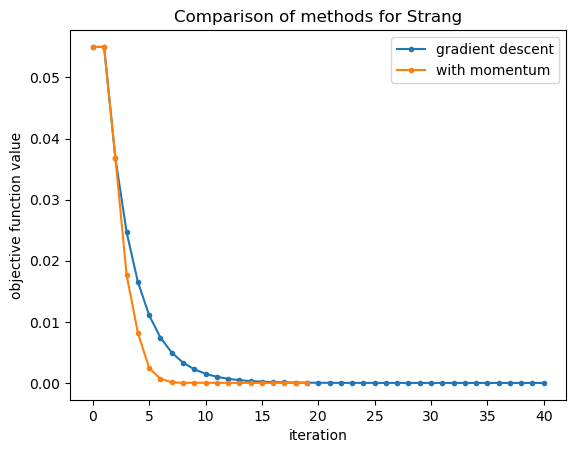

In [12]:
# Plot the objective function at each iteration of both methods

fig, ax = plt.subplots()
ax.plot(res.costs, '.-', label='gradient descent')
ax.plot(res2.costs, '.-', label='with momentum')
ax.set_xlabel('iteration')
ax.set_ylabel('objective function value')
ax.set_title(f"Comparison of methods for {function}")
ax.legend(loc='upper right')
plt.show()

In [ ]:
plt.close('all')